In [2]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from lib.mcalc import gcf2ann, spike2bin, spikeCoin
from lib.mviz import visSpk, visCurve

### Temporal correlation

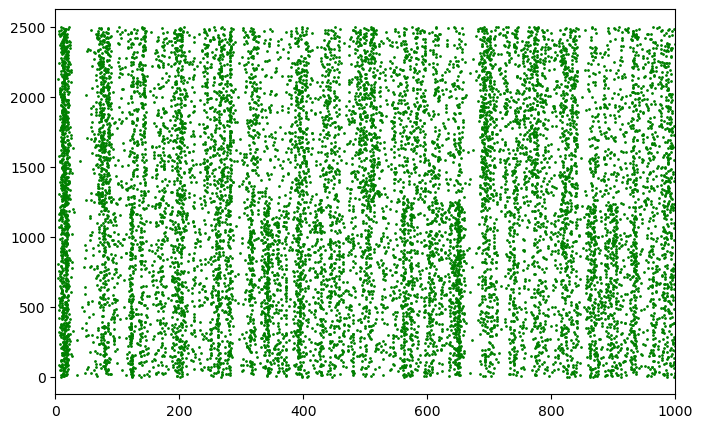

[5.3725 5.27   5.43   4.75   4.94   4.7525    nan]


/var/folders/32/1rfbx39j19j6ff9b4l5xgn3m0000gn/T/ipykernel_12780/2566066986.py:43: RuntimeWarning: invalid value encountered in divide
  print(rates.mean(axis=0)/np.array([Nm-2*nMSN, nMSN, nMSN, nMSN, nMSN, Nm-2*nMSN, Nf]))
/var/folders/32/1rfbx39j19j6ff9b4l5xgn3m0000gn/T/ipykernel_12780/2566066986.py:45: RuntimeWarning: invalid value encountered in divide
  rates = rates/np.array([nMSN, nMSN, Nf])


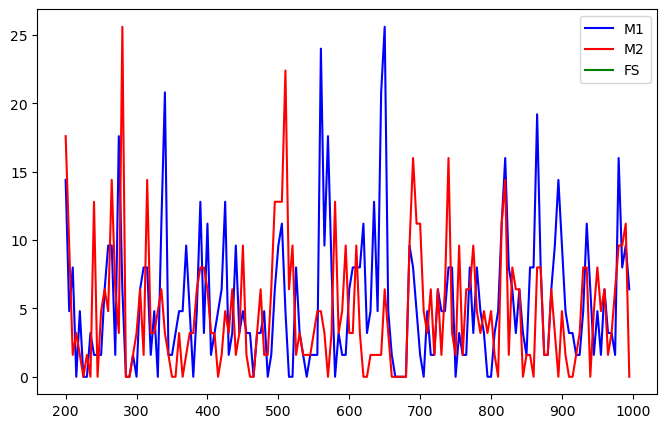

[5.43 4.75  nan]


In [3]:
# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 1
T, dt = 1000, 0.1

Nf = 0
D = 0.0
W = 0.1
B = 0.1

rectype = 'mmo'
recpath = './data/%s'%rectype
label = '/Nf%d-W%s-B%s-D%s/'%(Nf, W, B, D)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

colors = ['green']
# colors = ['blue', 'red']

plt.figure(figsize=(8, 5))
for e, c in enumerate(colors): 
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    plt.xlim(0, T)
# plt.ylim([2500, 2750])
plt.show()

nNums = [Nm, Nm, Nf]
labels = ['M1', 'M2', 'FS']
cs = ['blue', 'red', 'green']

plt.figure(figsize=(8, 5))
binsize = 5
for e, c in enumerate(colors):
    ta, tb = e*T, (e+1)*T
    idx = (ts>=ta) & (ts<tb)

    idBins = np.array([0, Nm-2*nMSN, Nm-nMSN, Nm, Nm+nMSN, Nm+2*nMSN, 2*Nm, 2*Nm+Nf]) + 1
    tmBins = np.arange(200, T+1, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    print(rates.mean(axis=0)/np.array([Nm-2*nMSN, nMSN, nMSN, nMSN, nMSN, Nm-2*nMSN, Nf]))
    rates = rates[:, np.array([2, 3, -1])]
    rates = rates/np.array([nMSN, nMSN, Nf])
    
    tms = tmBins[:-1] + e*T
    xs, ys = [tms]*len(nNums), rates.T
    for x, y, c in zip(xs, ys, cs):
        plt.plot(x, y, c=c)
plt.legend(labels)
plt.show()

print(np.mean(rates, axis=0))

In [232]:
# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 10
T, dt = 2500, 0.1

# range of parameters
if rectype == 'mmo':
    Nfs = [0, 25, 30, 60, 150, 250]
elif rectype == 'ffi':
    Nfs = [0, 25, 250]
Ws = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Bs = [0.1, 0.3, 0.5, 0.7, 0.9]
Ds = [0.0]

# # range of parameters
# Nfs = [0, 25, 250]
# Ws = [0.01, 0.1, 0.5]
# Bs = [0.1, 0.9]
# Ds = [0.0, 2.0, 4.0, 6.0, 10.0, 20.0, 40.0, 80.0]

recpath = './data/%s'%rectype

# extract data from raw recordings
frames = []
binKernel = np.ones(int(5 / dt))
grpsize = 25
binsize = 10
for Nf in Nfs:
    if Nf > 0:
        nNums = [Nm, Nm, Nf]
    else:
        nNums = [Nm, Nm, 1]
    for W in Ws:
        for B in Bs:
            for D in Ds:
                label = '/Nf%d-W%s-B%s-D%s/'%(Nf, W, B, D)
                data = np.load(recpath + label + 'spk.npz')
                es, ts = data.f.arr_0, data.f.arr_1
                data.close()

                # processing data
                rates = []
                corrs = []
                for e in range(epoch):
                    ta, tb = e*T+500, (e+1)*T
                    idx = (ts>=ta) & (ts<tb) & (es>=Nm-nMSN) & (es<=Nm+nMSN)

                    idBins = np.arange(Nm-nMSN, Nm+nMSN+1, grpsize)
                    tmBins = np.arange(0, T+1-500, binsize)
                    rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]*1e3/binsize/grpsize)

                    coV = np.corrcoef(rates[-1].T)
                    np.fill_diagonal(coV, 0.)

                    # set invalid values to zero
                    coV[np.isnan(coV)] = 0

                    ng = int(nMSN/grpsize)
                    ix = np.arange(0, ng)
                    corrs.append([   (np.sum(coV[np.ix_(ix, ix)])/ng/(ng-1) + np.sum(coV[np.ix_(ix+ng, ix+ng)])/ng/(ng-1))/2,
                                    np.sum(coV[np.ix_(ix, ix+ng)])/ng/ng])

                # output correlations
                corrs = np.array(corrs)
                frames.append([Nf, W, B, D, corrs[:,0].tolist(), corrs[:,1].tolist()])

colname = ['Nf', 'Win', 'Bin', 'Din', 'Wout', 'Bout']
stats = pd.DataFrame(frames, columns=colname)
stats.to_csv('./exp/%s/cor_stats.csv'%rectype, index=False)

(10, 55) (10, 55)


/Users/lihaog/miniconda3/envs/nest3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


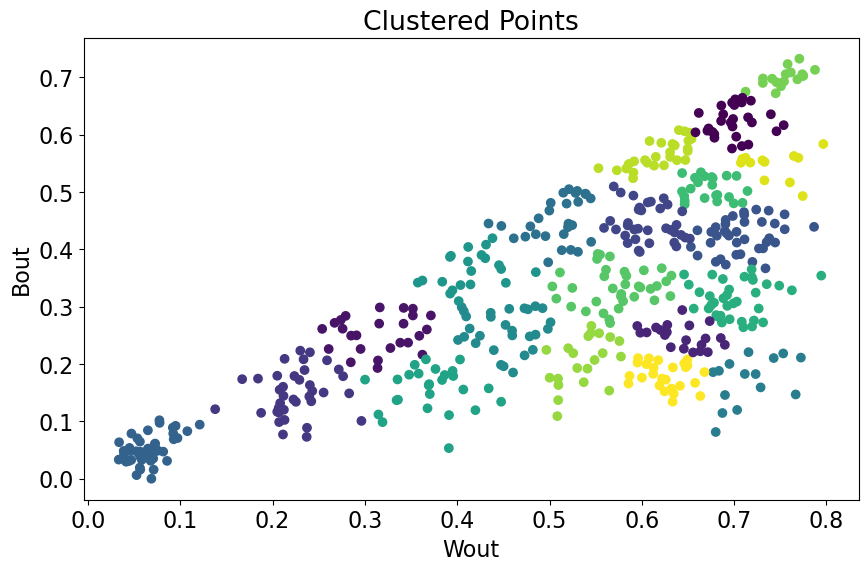

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import ast

# Read the CSV file
stats = pd.read_csv('./exp/%s/cor_stats.csv' % rectype)

# Function to convert string to numpy array
def string_to_np_array(string):
    return np.array(ast.literal_eval(string))

# Apply the conversion functions to the relevant columns
stats['Wout'] = stats['Wout'].apply(string_to_np_array)
stats['Bout'] = stats['Bout'].apply(string_to_np_array)
stats['Win'] = stats['Win'].apply(lambda x: float(x))
stats['Bin'] = stats['Bin'].apply(lambda x: float(x))

# Extract the relevant columns
cors = stats[['Nf', 'Wout', 'Bout', 'Win', 'Bin']]
va = 0
wa, ba = cors.loc[cors['Nf'] == va, 'Wout'], cors.loc[cors['Nf'] == va, 'Bout']
wa = np.stack(wa).transpose()
ba = np.stack(ba).transpose()

# Print the shapes of wa and ba
print(wa.shape, ba.shape)

# Flatten the arrays for clustering
points = np.column_stack((wa.flatten(), ba.flatten()))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=20)  # You can change the number of clusters
kmeans.fit(points)
labels = kmeans.labels_

# Plot the clustered points
plt.figure(figsize=(10, 6))
for i in range(wa.shape[0]):
    plt.scatter(wa[i], ba[i], c=labels[i * wa.shape[1]:(i + 1) * wa.shape[1]], marker='o', cmap='viridis')

plt.xlabel('Wout')
plt.ylabel('Bout')
plt.title('Clustered Points')
plt.show()

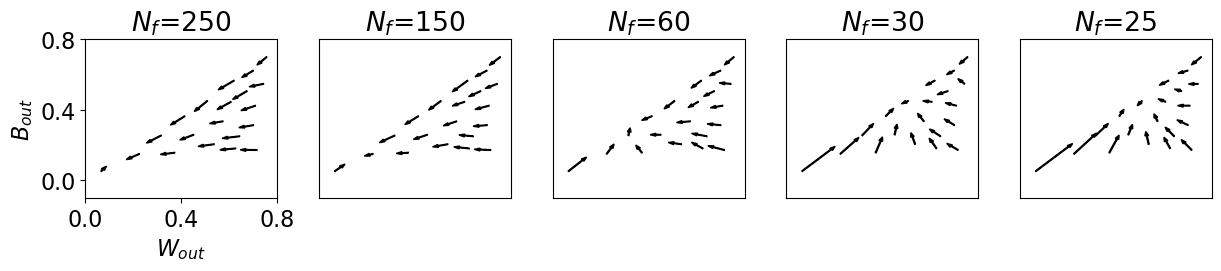

In [40]:
# plot font size
plt.rcParams.update({'font.size': 16})

if rectype == 'mmo':
    Nfsl = [250, 150, 60, 30, 25]
    xmax = ymax = 0.8
elif rectype == 'ffi':
    Nfsl = [250, 25, 0]
    xmax = ymax = 0.7
fig,axes = plt.subplots(1, len(Nfsl), figsize=(2.5*len(Nfsl), 3))

for j, vb in enumerate(Nfsl):
    wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']
    wb = np.stack(wb).transpose()
    bb = np.stack(bb).transpose()
    points_b = np.column_stack((wb.flatten(), bb.flatten()))

    ax = axes[j]
    ax.set_title(r'$N_f$=%d'%vb)
    for i in range(kmeans.n_clusters):
        # Calculate the mean of the points in the current cluster
        x = points[labels == i, 0].mean()
        y = points[labels == i, 1].mean()
        xx = points_b[labels == i, 0].mean()
        yy = points_b[labels == i, 1].mean()

        # Plot an arrow from the original mean point to the clustered mean point
        ax.arrow(x, y, xx - x, yy - y, width=xmax / 200, head_width=xmax / 50, edgecolor=None, facecolor='k', alpha=1.0)
    
    # xy range
    ax.set_xlim(0, xmax)
    ax.set_ylim(-0.1, ymax)
    
    if j == 0:
        ax.set_xlabel(r'$W_{out}$')
        ax.set_ylabel(r'$B_{out}$')
        ax.set_xticks([0, xmax/2, xmax])
        ax.set_yticks([0., ymax/2, ymax])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('./plot/%s/cor.pdf'%rectype, bbox_inches='tight')

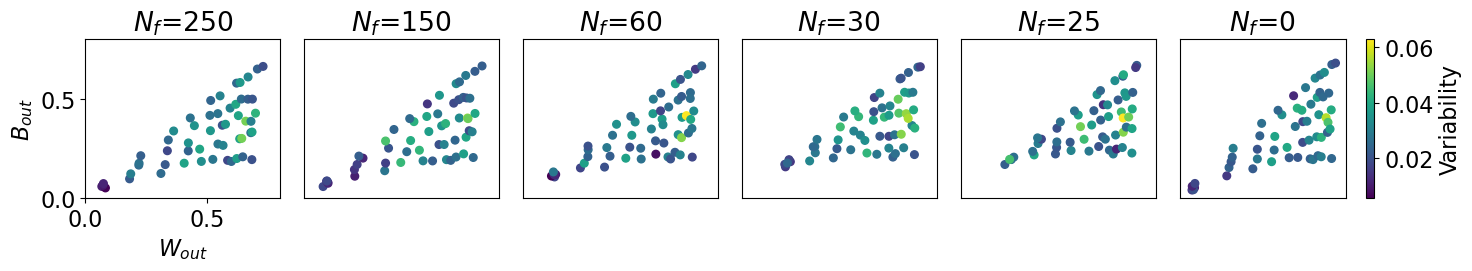

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

xss = []
yss = []
css = []
for vb in Nfsl + [0]:
    wb, bb = cors.loc[cors['Nf'] == vb, 'Wout'], cors.loc[cors['Nf'] == vb, 'Bout']
    wb = np.stack(wb).transpose()
    bb = np.stack(bb).transpose()
    xs = []
    ys = []
    cs = []
    for i in range(wb.shape[1]):
        points = np.column_stack((wb[:, i], bb[:, i]))
        mean_point = points.mean(axis=0)
        distances = np.sqrt(((points - mean_point) ** 2).sum(axis=1))
        std_dev = distances.std()

        xs.append(mean_point[0])
        ys.append(mean_point[1])
        cs.append(std_dev)
    xss.append(xs)
    yss.append(ys)
    css.append(cs)

sc = None
cmin, cmax = np.min(css), np.max(css)
fig, axes = plt.subplots(1, len(Nfsl)+1, figsize=(2.5 * (len(Nfsl)+1), 3.0))
for ax, xs, ys, cs, vb in zip(axes, xss, yss, css, Nfsl+[0]):
    ax.set_title(r'$N_f$=%d'%vb)
    sc = ax.scatter(xs, ys, c=cs, cmap='viridis', s=30, vmin=cmin, vmax=cmax)        
    ax.set_xlim([0., xmax])
    ax.set_ylim([0., ymax])
    if ax == axes[0]:
        ax.set_xlabel(r'$W_{out}$')
        ax.set_ylabel(r'$B_{out}$')
    else:
        ax.set_xticks([])
        ax.set_yticks([])

# Create a new axis for the colorbar
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.2)

# Add colorbar to the new axis
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('Variability')


plt.tight_layout()
plt.savefig('./plot/%s/cor_dist.pdf' % rectype, bbox_inches='tight')

In [ ]:
# Load the data
stats = pd.read_csv('./exp/%s/cor_stats.csv'%rectype)
stats['Wout'] = stats['Wout'].apply(string_to_np_array)
stats['Bout'] = stats['Bout'].apply(string_to_np_array)

# Define fixed Win and Bin
fixed_Win = 0.5  # Example value
fixed_Bin = 0.1  # Example value

# Create the plot
plt.figure(figsize=(4, 3))

# Define colormap
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=stats['Din'].min(), vmax=stats['Din'].max())
colors = cmap(norm(stats['Din'].unique()))

# Plot data
for marker, Nf in zip(['o', 's', '^'], [0, 25, 250]):
    fixed_Nf = Nf   # Example value

    # Filter the DataFrame
    cors = stats[(stats['Win'] == fixed_Win) & 
                 (stats['Bin'] == fixed_Bin) & 
                 (stats['Nf'] == fixed_Nf)]

    # Loop through unique Din values and plot Bout vs Wout
    for color, din in zip(colors, cors['Din'].unique()):
        wb, bb = cors.loc[cors['Din'] == din, 'Wout'], cors.loc[cors['Din'] == din, 'Bout']
        wb = np.stack(wb).transpose()
        bb = np.stack(bb).transpose()
        
        # Calculate the average and standard deviation
        avg_wb = np.mean(wb)
        avg_bb = np.mean(bb)
        std_wb = np.std(wb)
        std_bb = np.std(bb)
        
        # Plot the error bars
        plt.errorbar(avg_wb, avg_bb, xerr=std_wb, yerr=std_bb, fmt=marker, color=color, ecolor=color, elinewidth=2, capsize=4, alpha=0.5)

# Create custom legends
handles = [plt.Line2D([0], [0], marker='o', color='w', label=r'$N_f$=0', markerfacecolor='k', markersize=10),
           plt.Line2D([0], [0], marker='s', color='w', label=r'$N_f$=25', markerfacecolor='k', markersize=10),
           plt.Line2D([0], [0], marker='^', color='w', label=r'$N_f$=250', markerfacecolor='k', markersize=10)]
plt.legend(handles=handles, title=r'$N_f$')

# Create colorbar for Din
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(r'$\Delta \mathrm{delay}$')

# Set plot titles and labels
plt.title(r'$W_{in}$=%s, $B_{in}$=%s'%(fixed_Win, fixed_Bin))
plt.xlabel(r'$W_{out}$')
plt.ylabel(r'$B_{out}$')

# Show the plot
plt.tight_layout()
plt.savefig('./exp/mmo/delay_effect.pdf')
plt.close()

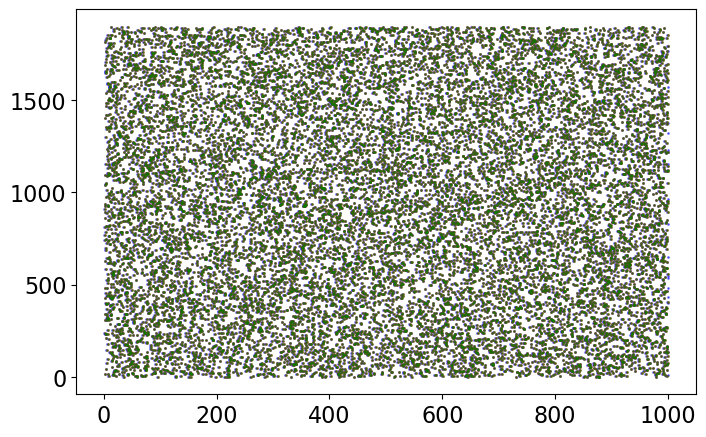

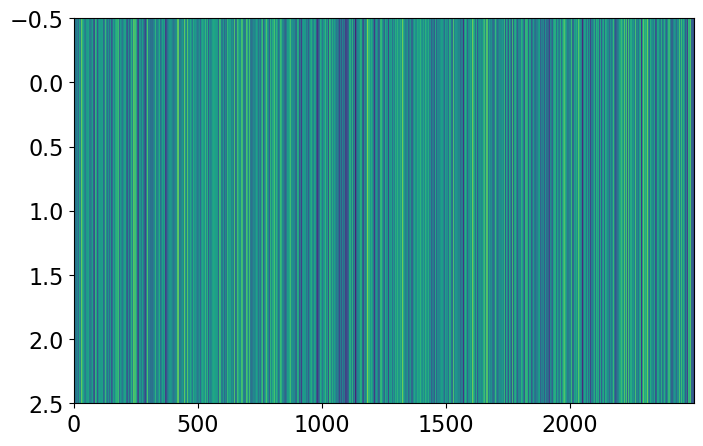

In [128]:
# data setting
Nm = 1250
nMSN = Nm // 10
epoch = 1
T, dt = 1000, 0.1

Nfs = [0, 25, 250]
colors = ['blue', 'red', 'green']
D = 0.0
W = 0.1
B = 0.1

rectype = 'mmo'
recpath = './data/%s'%rectype

inpIds, inpTimes = [], []
for Nf in Nfs:
    label = '/Nf%d-W%s-B%s-D%s/'%(Nf, W, B, D)
    data = np.load(recpath + label + 'inp.npz')
    inpIds.append(data.f.arr_0)
    inpTimes.append(data.f.arr_1)

initStates = []
for Nf in Nfs:
    label = '/Nf%d-W%s-B%s-D%s/'%(Nf, W, B, D)
    data = np.load(recpath + label + 'init.npz')
    initStates.append(data.f.arr_0)

plt.figure(figsize=(8, 5))
for e, c in enumerate(colors): 
    plt.scatter(inpTimes[e], inpIds[e]-np.min(inpIds[e]), s=1, c=c, alpha=0.5)
plt.show()

plt.figure(figsize=(8, 5))
plt.imshow(np.array(initStates).squeeze(), aspect='auto')
plt.show()